<a href="https://colab.research.google.com/github/desultir/assign1/blob/master/MNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade scipy
!pip install --upgrade numpy


Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.2.1)
    100% |████████████████████████████████| 17.3MB 1.7MB/s 
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2


In [0]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import h5py
from google.colab import drive
import time


In [0]:
drive.mount('/content/drive', force_remount=True)
with h5py.File('/content/drive/My Drive/Colab Notebooks/Input/train_128.h5','r') as H:
  data = np.copy(H['data'])
with h5py.File('/content/drive/My Drive/Colab Notebooks/Input/train_label.h5','r') as H:
  label = np.copy(H['label'])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import pickle
import glob

model_dir = "/content/drive/My Drive/Colab Notebooks/Models/{}.pk"

def list_models():
  return glob.glob(model_dir.format("*"))




In [0]:
# need to normalize input data to avoid overflow/underflow in initial epochs
# normalize each feature independently
# options are zscore, minmax
def preprocess(input_array, method='zscore'):
  if method == 'zscore':
    for i in range(input_array.shape[1]):
      mean = np.mean(input_array[:, i])
      std = np.std(input_array[:, i])
      input_array[:, i] = (input_array[:, i] - mean) / std
  elif method == 'minmax':
    for i in range(input_array.shape[1]):
      # range 0 to max
      input_array[:, i] = (input_array[:, i] - np.min(input_array[:, i]))
      # range 0 to 2
      input_array[:, i] /= (np.max(input_array[:, i]) / 2)
      # range -1 to 1
      input_array[:, i] -= 1
      

In [0]:
#use stratified sampling to split train into train/validation
#this dataset is actually balanced but still good practice
def split(dataset, labels, train_percent=.85):
  count = len(dataset)
  num_classes = np.max(label) + 1
  train = []
  train_target = []
  validate = []
  validate_target = []
  for i in range(num_classes):
    class_data = np.ravel(np.argwhere(label == i))
    np.random.shuffle(class_data)
    cutoff = int(len(class_data) * train_percent)
    train_idx = class_data[:cutoff]
    val_idx = class_data[cutoff:]
    train.append(dataset[train_idx])
    train_target.append(labels[train_idx])
    validate.append(dataset[val_idx])
    validate_target.append(labels[val_idx])
    
  return np.vstack(train), np.hstack(train_target), np.vstack(validate), np.hstack(validate_target)

In [0]:
#need to one-hot encode labels to map to N output nodes (1 per class)
#ie convert each label into a (10,) vector where the relevant column is 1

def OHE(input_array, num_classes=10):
  output = []
  for x in input_array:
    output.append(np.zeros((10,)))
    output[-1][x] = 1
  return np.vstack(output)

In [0]:
## implemented formulae from here: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
class InitWeights(object):
  def xavier(self, n_in, n_out, uniform=True):
    if uniform:
      bounds = np.sqrt(6) / (np.sqrt(n_in + n_out))
      return self._uniform(n_in, n_out, bounds) 
    else:
      stddev = np.sqrt(2) / (np.sqrt(n_in + n_out))
      return self._truncated_normal(n_in, n_out, stddev)
    
  def he(self, n_in, n_out, uniform=True):
    if uniform:
      bounds = np.sqrt(2) / (np.sqrt(n_in))
      return self._uniform(n_in, n_out, bounds)      
    else:
      stddev = np.sqrt(6) / (np.sqrt(n_in))
      return self._truncated_normal(n_in, n_out, stddev)
 
  def _uniform(self, n_in, n_out, bounds):
    W = np.random.uniform(
        low=-bounds,
        high=bounds,
        size=(n_in, n_out)
      )
    return W
  
  def _truncated_normal(self, n_in, n_out, stddev):
    W = np.random.normal(
        loc=0,
        scale=stddev,
        size=(n_in, n_out)
      )
    #truncate results - anything > 2 stddev out gets clipped
    W[W> 2*stddev] = 2*stddev
    W[W<-2*stddev] = -2*stddev
    return W
  
  def __init__(self, init_method="xavier"):
    if init_method=="xavier":
      self.f = self.xavier
    elif init_method=="he":
      self.f = self.he

In [0]:
def calc_MSE(y, y_hat):
  error = y-y_hat
  return np.mean(np.sum(error**2, axis=1))

def labels_from_preds(preds):
  return np.argmax(preds, axis=1)

def calc_accuracy(labels, target):
  return np.sum(labels == target) / len(target)

#wasn't sure if we could use a package to shuffle so found this code: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
  
  

The function for ReLU


$ f(x) = \begin{cases}
    x & \mbox{if } x > 0 \\
    0 & \mbox{otherwise}
\end{cases}$

The function for ReLU's derivative

$ f(x) = \begin{cases}
    1 & \mbox{if } x > 0 \\
    0 & \mbox{otherwise}
\end{cases}$


The function for Leaky ReLU


$ f(x) = \begin{cases}
    x & \mbox{if } x > 0 \\
    0.01x & \mbox{otherwise}
\end{cases}$

The function for Leaky ReLU's derivative

$ f(x) = \begin{cases}
    1 & \mbox{if } x > 0 \\
    0.01 & \mbox{otherwise}
\end{cases}$


In [0]:
from scipy.special import softmax

class Activation(object):
    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
      
    def ReLU(self, x):
        x[x<0] =0
        return x
      
    def ReLU_deriv(self, a):
        der = np.zeros(a.shape)
        der[a>0] =1
        return der
      
    def leaky_ReLU(self, x):
        x = np.where(x > 0, x, x*0.01)
        return x
      
    def leaky_ReLU_deriv(self, a):
        der = np.full(a.shape, 0.01)
        der[a>0] =1
        return der
      
    def softmax(self, x):
        # apply max normalization to avoid overflow
        if len(x.shape) > 1:
          x_norm = (x.T - np.max(x, axis=1)).T
          return softmax(x_norm, axis=1)
        else:
          x_norm = x - np.max(x)
          return softmax(x_norm)
      
    def softmax_deriv(self, a):
        return np.ones(a.shape)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.logistic
            self.f_deriv = self.logistic_deriv
        elif activation == 'tanh':
            self.f = self.tanh
            self.f_deriv = self.tanh_deriv
        elif activation == 'relu':
            self.f = self.ReLU
            self.f_deriv = self.ReLU_deriv
        elif activation == 'leaky_relu':
            self.f = self.leaky_ReLU
            self.f_deriv = self.leaky_ReLU_deriv
        elif activation == 'softmax':
            self.f = self.softmax
            self.f_deriv = self.softmax_deriv
            

In [0]:
class Loss_function(object):
    def MSE(self, y, y_hat):
        error = y-y_hat
        loss=np.sum(error**2)
        return loss
      
    def Cross_entropy(self, y, y_hat):
        return -np.log(y_hat[np.argmax(y)])
      
    def l2_reg(self, reg_weight, layers, sample_weight):
        accum = 0
        for layer in layers:
          accum += np.sum(np.square(layer.W))
          
        return accum*reg_weight*sample_weight/2
        
    def __init__(self,loss='cross_entropy'):
        if loss == 'MSE':
            self.loss = self.MSE
        elif loss == 'cross_entropy':
            self.loss = self.Cross_entropy

In [0]:

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None,
                init_uniform=True, weight_decay=None, last_layer=False):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        :type init_uniform: bool
        :param init_uniform: Whether to draw init weights from uniform dist (else normal)
        
        :type weight_decay: float/None/False
        :param weight_decay: Weight to apply to l2 reg loss factor (else none/false)
        """
        self.input=None
        self.dropout_cache=None
        self.activation=Activation(activation).f
        self.last_layer=last_layer
        
        if activation=='relu':
          self.init_weights = InitWeights("he").f
        else:
          self.init_weights = InitWeights("xavier").f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        if W is not None:
          self.W = W
        else:
          self.W = self.init_weights(n_in, n_out, init_uniform)

        if b is not None:
          self.b = b
        else:
          self.b = np.zeros(n_out,)  
          
        self.weight_decay = weight_decay
          
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # create arrays to store the velocity values for momentum calculation
        self.vW = np.zeros(self.W.shape)
        self.vb = np.zeros(self.b.shape)
        
        # Create arrays to store the gamma and beta values for batch norm. @
        self.gamma = np.zeros(n_out,)
        self.beta = np.zeros(n_out,)
        
        self.grad_gamma = np.zeros(self.gamma.shape,)
        self.grad_beta = np.zeros(self.beta.shape,)
    
    def dropout(self, nodes, probability):
        #This distribution decides what nodes will be on or not. We then rescale the on nodes proportionally to the probability that it is off.
        
        active_nodes = np.random.binomial(1, probability, size=nodes.shape) / probability
        output = np.multiply(nodes, active_nodes)
        return output, active_nodes
    
    def forward(self, input, probability):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        
        if self.last_layer:
            probability=1
        
        self.output, self.dropout_cache = self.dropout(self.output, probability)
        return self.output
    
    def backward(self, delta, output_layer=False, sampleweight=1):
        delta *= self.dropout_cache
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        
        if self.weight_decay:
            self.grad_W += self.W * self.weight_decay * sampleweight
        self.grad_b = np.sum(delta, axis=0)
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta
      
    def forward_BN(self, input, probability):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        gamma: parameter to be learned
        beta: parameter to be learned
        '''
        lin_output = np.dot(input, self.W) # Removed bias because it is forced to zero when normalizing ~(0,1) @
        
        # Can apply batch norm before or after activation function: https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/ @
        mu = np.mean(lin_output, axis=0) # Calculate the mean of each feature.
        var = np.var(lin_output, axis=0) # Calculat the variance of each feature.    
                
        lin_output_norm = (lin_output - mu) / np.sqrt(var + 1e-8) # Normalise. Note the 1e-8 used incase var = 0.  
        lin_output_norm = self.gamma * lin_output_norm + self.beta # Add gamma and beta so the mean and vairaince of distribution can be tuned.
        
        self.cache = (lin_output, lin_output_norm, mu, var)  # Store values for back propogation.   
                      
        self.output = (
            lin_output_norm if self.activation is None
            else self.activation(lin_output_norm)
        )
        self.input=input # I'm not sure what this does? @
        
        if self.last_layer:
            probability=1
        
        self.output, self.dropout_cache = self.dropout(self.output, probability)
        return self.output                                       

    def backward_BN(self, delta, dy_hat, output_layer=False, sampleweight=1):
      
        # Unpack cache variables
        X, X_norm, mu, var = self.cache
        
        # Define variables to make back prop clearer
        n_in, n_dims = X.shape
        
        X_mu = X - mu
        std_inv = 1 / np.sqrt(var + 1e-8)
        
        # Back prop step by step for clarity. I followed this procedure: https://wiseodd.github.io/techblog/2016/07/04/batchnorm/
        # Can also condense into a single calculation like this: https://cthorey.github.io/backpropagation/
        dX_norm = delta * self.gamma
        dvar = np.sum(dX_norm * X_mu, axis=0) * -0.5 * std_inv**3
        dmu = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)
  
        self.grad_W = (dX_norm * std_inv) + (dvar * 2 * X_mu / n_in) + (dmu / n_in)

        self.grad_gamma = np.sum(delta * X_norm, axis=0)
        self.grad_beta = np.sum(delta, axis=0)            
        
        if self.weight_decay:
          self.grad_W += self.W * self.weight_decay * sampleweight      
        
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta
      

In [0]:

class MLP:
    """
    """      
    def __init__(self, layers=None, activation=[None,'tanh','tanh'], init_uniform=True, weight_decay=False, from_file=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        :param init_uniform: Whether to draw init weights from uniform dist (else normal)
        :param weight_decay: lambda for strength of l2 regularization on weights (else False/None for no reg)
        :param from_file: a file to load to get pretrained weights. 
        """        
        ### initialize layers
        self.layers=[]
        self.params= {'activation':activation, 'layers':layers, 'weight_decay': weight_decay, 'init_uniform': init_uniform}
        
        self.es_epochs=None
        if from_file:
          dumped_model = self._load_model(from_file)
          self.params = dumped_model['params']
          self.activation=self.params['activation']
          layers = self.params['layers']
          init_uniform = self.params['init_uniform']
          for i in range(len(self.params['layers'])-1):
              if i==len(self.params['layers'])-2:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],  
                                              W=dumped_model['weights'][i][0], b=dumped_model['weights'][i][1], weight_decay=weight_decay, init_uniform=init_uniform,last_layer=True))
              else:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],  
                                              W=dumped_model['weights'][i][0], b=dumped_model['weights'][i][1], weight_decay=weight_decay, init_uniform=init_uniform))
        else:
          self.activation=activation
          for i in range(len(layers)-1):
              if i==len(layers)-2:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1], weight_decay=weight_decay, init_uniform=init_uniform,last_layer=True))
              else:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1], weight_decay=weight_decay, init_uniform=init_uniform))
    
    def forward(self,input, dropout_p=1):
        for layer in self.layers:
            output=layer.forward(input, dropout_p)
            input=output
        return output
    
    #@ Can combine this with forward above with an if statement. Just wanted to keep separte for now until I know it works.
    def Forward_BN(self,input, dropout_p=1):
        for layer in self.layers:
            output =layer.forward_BN(input, dropout_p)
            input=output
        return output
      
    def set_early_stopping(self, validation, validation_labels, num_epochs=10):
        # for early stopping
        self.validation = validation
        self.validation_labels = labels_from_preds(validation_labels)
        self.es_epochs = num_epochs
      
    def calculate_loss(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # call to loss function
        loss=[]
        delta=[]
        dy_hat=[] # store derivative of output for use in BN_backward @

        for i, single_y in enumerate(y):
          loss.append(Loss_function('MSE').loss(single_y, y_hat[i]))
          error = single_y-y_hat[i]
          # calculate the delta of the output layer
          delta.append(np.array(-error*activation_deriv(y_hat[i])))
        # return loss and delta
        loss = np.array(loss)
        if self.params['weight_decay']:
          loss += Loss_function().l2_reg(self.params['weight_decay'], self.layers, len(y)/self.Xcount)

        return loss,np.array(delta)
      
    def calculate_loss_BN(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # call to loss function
        loss=[]
        delta=[]
        dy_hat=[] # store derivative of output for use in BN_backward @

        for i, single_y in enumerate(y):
          loss.append(Loss_function('MSE').loss(single_y, y_hat[i]))
          error = single_y-y_hat[i]
          # calculate the derivative of the output layer @
          dy_hat.append(np.array(activation_deriv(y_hat[i])))
          # calculate the delta of the output layer
          delta.append(np.array(-error*activation_deriv(y_hat[i])))
        # return loss and delta
        loss = np.array(loss)
        if self.params['weight_decay']:
          loss += Loss_function().l2_reg(self.params['weight_decay'], self.layers, len(y)/self.Xcount)

        return loss,np.array(delta), np.array(dy_hat) #@
        
    def backward(self,delta, sampleweight):
        delta=self.layers[-1].backward(delta,output_layer=True, sampleweight=sampleweight)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta, sampleweight=sampleweight)
    
    #@ can combine this with backwards above with an if statement. Just wanted to keep separte for now until I know it works.
    def Backward_BN(self, delta, dy_hat, sampleweight):
        delta =self.layers[-1].backward_BN(delta, dy_hat, output_layer=True, sampleweight=sampleweight)
        for layer in reversed(self.layers[:-1]):
            delta =layer.backward_BN(delta, dy_hat, sampleweight=sampleweight)                 
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
            
    def update_momentum(self, lr, mom):
        for layer in self.layers:
            layer.vW = mom * layer.vW + lr * layer.grad_W
            layer.vb = mom * layer.vb + lr * layer.grad_b
            layer.W -= layer.vW
            layer.b -= layer.vb 
            
    def update_BN(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
            layer.gamma -= lr * layer.grad_gamma
            layer.beta -= lr * layer.grad_beta     

    def fit(self,X,y,learning_rate=0.1, epochs=100, dropout_p=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        self.Xcount = len(X)
        if self.es_epochs:
            validation_acc = np.zeros(epochs)
        for k in range(epochs):
            #print('epoch', k)
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i], dropout_p)
                # backward pass
                loss[it],delta=self.calculate_loss([y[i]],[y_hat])
                self.backward(delta, 1/self.Xcount)
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
            if not k % 10:
              print(".", end="")
            if self.es_epochs:
              preds = self.predict(self.validation)
              validation_acc[k] = calc_accuracy(labels_from_preds(preds), self.validation_labels)
              if k - np.argmax(validation_acc) > self.es_epochs:
                print("Haven't improved accuracy on validation set in {} epochs, stopping".format(self.es_epochs))
                break
        return to_return
      
    def fit_mb(self,X,y,mini_batch_size,learning_rate=0.1, epochs=100, dropout_p=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        :param early_stop: int: stop if haven't improved in this many epochs
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs) #array to store values of mean loss for each epoch for plotting later
        if self.es_epochs:
            validation_acc = np.zeros(epochs)
        self.Xcount = len(X)
        
        for k in range(epochs): #for each epoch
            X, y = shuffle_in_unison(X, y) #shuffle the input data and input targets
            loss=np.zeros(X.shape[0]) #create array of zeros whose lengths = #samples.
            
            #partition training data (X, y) into mini-batches
            for j in range(0, X.shape[0], mini_batch_size):
              X_mini = X[j:j + mini_batch_size]
              y_mini = y[j:j + mini_batch_size]
              # forward pass
              y_hat = self.forward(X_mini, dropout_p) #forward feed the mini_batches to get outputs (y_hat)
              
              # backwards pass
              loss[j:j + mini_batch_size], delta=self.calculate_loss(y[j:j + mini_batch_size], y_hat) #input y and y_hat into calculate_loss. Output = loss and delta
              self.backward(delta, mini_batch_size/self.Xcount) #pass delta from calculate_loss to backward.

              # update
              self.update(learning_rate)
            to_return[k] = np.mean(loss) #add mean loss to to_return
            if not k % 10:
              print(".", end="")
            if self.es_epochs:
              preds = self.predict(self.validation)
              validation_acc[k] = calc_accuracy(labels_from_preds(preds), self.validation_labels)
              if k - np.argmax(validation_acc) > self.es_epochs:
                print("Haven't improved accuracy on validation set in {} epochs, stopping".format(self.es_epochs))
                break
              
        return to_return[:k]
      
    def fit_mb_BN(self,X,y,mini_batch_size,learning_rate=0.1, epochs=100, dropout_p=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        :param early_stop: int: stop if haven't improved in this many epochs
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs) #array to store values of mean loss for each epoch for plotting later
        if self.es_epochs:
            validation_acc = np.zeros(epochs)
        self.Xcount = len(X)
        
        for k in range(epochs): #for each epoch
            X, y = shuffle_in_unison(X, y) #shuffle the input data and input targets
            loss=np.zeros(X.shape[0]) #create array of zeros whose lengths = #samples.
            
            #partition training data (X, y) into mini-batches
            for j in range(0, X.shape[0], mini_batch_size):
              X_mini = X[j:j + mini_batch_size]
              y_mini = y[j:j + mini_batch_size]
              # forward pass
              y_hat = self.Forward_BN(X_mini, dropout_p) #forward feed the mini_batches to get outputs (y_hat)
              
              # backwards pass
              loss[j:j + mini_batch_size], delta, dy_hat=self.calculate_loss_BN(y[j:j + mini_batch_size], y_hat) #input y and y_hat into calculate_loss. Output = loss and delta
              self.Backward_BN(delta, dy_hat, mini_batch_size/self.Xcount) #pass delta from calculate_loss to backward.

              # update
              self.update_BN(learning_rate)
            to_return[k] = np.mean(loss) #add mean loss to to_return
            if not k % 10:
              print(".", end="")
            if self.es_epochs:
              preds = self.predict(self.validation)
              validation_acc[k] = calc_accuracy(labels_from_preds(preds), self.validation_labels)
              if k - np.argmax(validation_acc) > self.es_epochs:
                print("Haven't improved accuracy on validation set in {} epochs, stopping".format(self.es_epochs))
                break
              
        return to_return[:k]
      
    def fit_SGD_momentum(self,X,y,learning_rate=0.1, epochs=100, momentum=0.9, dropout_p=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        self.Xcount = len(X)
        if self.es_epochs:
            validation_acc = np.zeros(epochs)
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            
            # loop through training examples
            for j in range(X.shape[0]):
              i=np.random.randint(X.shape[0])
                
              # forward pass
              y_hat = self.forward(X[i], dropout_p)
                
              # backward pass
              loss[j],delta=self.calculate_loss([y[i]],[y_hat])
              self.backward(delta, X.shape[0]/self.Xcount)
                
              # update
              self.update_momentum(learning_rate, momentum)
            to_return[k] = np.mean(loss)
            if not k % 10:
              print(".", end="")
            if self.es_epochs:
              preds = self.predict(self.validation)
              validation_acc[k] = calc_accuracy(labels_from_preds(preds), self.validation_labels)
              if k - np.argmax(validation_acc) > self.es_epochs:
                print("Haven't improved accuracy on validation set in {} epochs, stopping".format(self.es_epochs))
                break
        return to_return  

    def predict(self, x):
        x = np.array(x)
        output = []
        for i in np.arange(x.shape[0]):
            output.append(self.forward(x[i,:]))
        return np.vstack(output)
      

    def save_model(self, name):
      model = {'params':self.params, 'weights':[]}
      for x in self.layers:
        model['weights'].append((x.W, x.b))
        
      with open(model_dir.format(name), 'wb') as f:
        pickle.dump(model, f)
        
    def _load_model(self, name):
      with open(model_dir.format(name), 'rb') as f:
        return pickle.load(f)

In [0]:

np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(procdata, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)

relu = True

if relu:
  nn = MLP([128,69,30,10], [None,'relu','relu', 'softmax'])
  nn.set_early_stopping(validate, validate_target, 10)
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.01, epochs=500, mini_batch_size=32)
  print("{}s to train".format(time.time() - start))
else:
  nn = MLP([128,60,10], [None,'logistic','tanh'], init_uniform=False, weight_decay=0.5)
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.01, epochs=500, mini_batch_size=32)
  print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

..

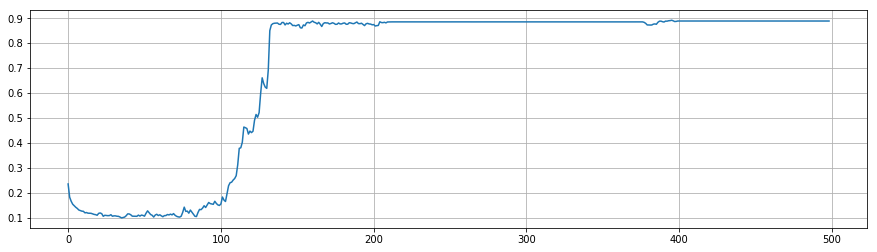

In [29]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

In [30]:
#get validation score
#nn = load_model("tdm1")
preds = nn.predict(validate)

loss = calc_MSE(preds, validate_target)
calc_accuracy(labels_from_preds(preds), labels_from_preds(validate_target)) # we have to de-OHE the predictions and the target data

/usr/local/lib/python3.6/dist-packages/scipy/special/_logsumexp.py:112: RuntimeWarning: underflow encountered in exp
  tmp = np.exp(a - a_max)
/usr/local/lib/python3.6/dist-packages/scipy/special/_logsumexp.py:215: RuntimeWarning: underflow encountered in exp
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: underflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until


0.11244444444444444

In [0]:
nn.save_model("relu.1")

calc_accuracy(labels_from_preds(preds), labels_from_preds(validate_target)) # we have to de-OHE the predictions and the target data

0.8756666666666667

In [0]:
np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(data, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)
second_layer = False
relu = False
if second_layer:
  nn = MLP([128,60,30,10], [None,'logistic','logistic','tanh'])
elif relu:
  nn = MLP([128,60,10], [None, 'relu', 'relu'], False)
  start = time.time()
  MSE = nn.fit_mb_BN(train, train_target, 32, learning_rate=0.001, epochs=25, dropout_p=1)
  print("{}s to train".format(time.time() - start))
else:
  nn = MLP([128,60,10], [None,'logistic','tanh'], False)
  start = time.time()
  MSE = nn.fit_mb_BN(train, train_target, 32, learning_rate=0.01, epochs=25, dropout_p=1)
  print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

In [0]:
len(train)
len(validate)
train.shape

(51000, 128)

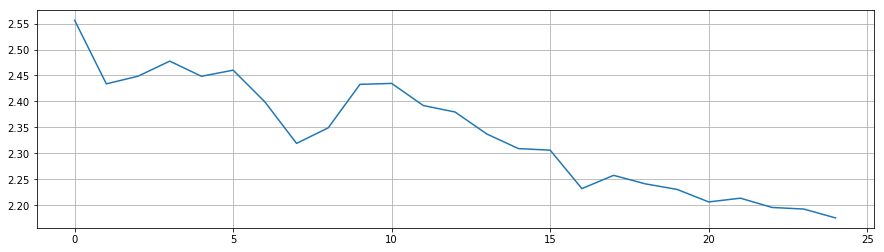

In [0]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

##1.0 Introduction
The experiment task consisted of building a neural network to perform multi-class classification on a supplied dataset without the use of Deep Learning frameworks (e.g. TensorFlow, Caffe, and KERAS). The dataset consisted of 60,000 labeled training samples and 10,000 unlabeled test samples. The structure of the data (e.g. image, video, etc) was unknown. The performance of the neural network was evaluated in terms of the accuracy metric. Various neural network structures and parameters were trailed to maximise speed and accuracy.

The objective of building the neural network without Deep Learning frameworks was to gain a comprehensive understanding of the math and mechanics behind neural networks. This is important due to the increasing number of fields where neural networks are the state-of-the-art solution for machine learning.

##2.0 Methods
###2.1 Equipment
The programing language Python3 was used to build the neural network. A **COMPUTER XX@** with the following specifications was used to run the neural network:
*   Processor:
*   Memory:
*   Operating system:

###2.2 Preprocessing

Preprocessing data before feeding it to a Neural Network is important for many reasons. Firstly, greatly differing magnitudes between different features can lead to the network assigning false importance to the larger features. Preprocessing also speeds up convergence - centering the data can mitigate the vanishing gradient problem on activation functions such as sigmoid and tanh, while normalization can mitigate the exploding gradient problem with ReLU activation passing through huge net values.

The method selected was z-score normalization. This is a two-step process - run on each feature independetly. First the mean of each feature is subtracted to centre it on zero; secondly the standard deviation is calculated and the feature divided by the standard deviation. The end result is features with zero mean and standard deviation 1. This ensures most of the variance is within the -1 to 1 range where most activation functions have the largest gradient.

The output data was also one-hot encoded to create one column per output class. This maps back to the output of a neural network with one node per output class.

###2.3 Weight Initialization

The goal of weight initialization is to initialize the layers of the network with small random numbers to ensure that different nodes learn different things. We want to preserve variance through the network, so we examine each layer independently with the goal that outputs of a layer should have the same variance as the inputs. In order to preserve this variance for different activation functions, two methods of weight initialization are employed.

Both methods are used to calculate the parameters of a distribution from which weights are selected. Two options are presented to the user - a uniform distribution and a truncated normal distribution. A truncated normal distribution is selected to remove large outliers - any weight with absolute value larger than the maximum of 2 standard deviations has its absolute value set to this limit.  

###2.3.1 Xavier Initialization

For sigmoid and tanh activation functions, the preservation of variance depends on both the number of inputs and the number of outputs of the layer. Firstly, for the truncated normal case, we want to average the number of inputs and outputs to select parameters for our distribution which are optimal for both.

$$Var(W) = \frac{1}{\frac{n_{in} + n_{out}}{2}} = \frac{2}{n_{in} + n_{out}} $$                 
$$\sigma(W) = \sqrt{\frac{2}{n_{in} + n_{out}}} $$

To select bounds for a uniform distribution, we apply the function
$$Var(\mathit{Uniform(-limit, limit)}) = \frac{limit^2}{3} $$
$$Var(W) = \frac{2}{n_{in} + n_{out}}  \Leftrightarrow  limit = \sqrt{\frac{6}{n_{in}+n_{out}}} $$


###2.3.2 He Initialization

For ReLU activation, we encounter the issue that a ReLU unit halves the variance - the variance of negative numbers is nullified. So we must double the above formulae to compensate. One further simplification is that in their original paper, *He. et al* demonstrated that their initialization scheme works for both forward and backward passes, meaning we only need to consider $n_{in}$ and not the average of both. For truncated normal we derive the bounds:
$$ Var(W) = \frac{2}{n_{in}} $$

$$ \sigma(W) = \sqrt{\frac{2}{n_{in}}} $$

Applying the function for the variance of limits from the Xavier Initialization section, we derive the bounds for uniform He initialization:

$$ limit = \sqrt{\frac{6}{n_{in}}} $$

##2.4 Training

### 2.4.1 Gradient Descent
Gradient descent is a machine learning optimization method used in deep learning to calculate the model parameters (weights and biases) that minimise the cost function. The gradient descent method invovles iterating through a training dataset and updating weights and baises in accordance with the gradient of error. There are three types of gradient descent. Each uses a different number of training examples to update the model parameters:
*   **Batch Gradient Descent** uses the entire training dataset to calculate gradients and update the parameters. Because the entire training dataset is considered parameters updates are smooth however, it can take a long time to make a single update.
*   **Stochastic Gradient Descent (SGD)** uses a single randomly selected sample from the training dataset to calculate gradients and update the parameters. Parameter updates are fast but very noisey.
*   **Mini-batch Gradient Descent** uses a subset of the training data (e.g. batches of 1000 samples) to calculate gradients and update the parameters. Mini-batch gradient descent is a compromise between batch and stochastic gradient descent. The mini-batch size can be adjusted to find the appropriate balance between fast convergence and noisey updates. 

Mini-batch gradient descent was inplemented in the neural network due to the flexibility provided by the adjustable mini-batch size. Mini-batch sizes between 32 and 512 samples were used in accordance with the findings of *Keskar et al, 2017.* *Keskar et al* observed that larger batch-sizes resulted in a degradation in the quality of the model, as measured by its ability to generalize. A hybrid of batch gradient descent and stocahastic gradient descent was also implemented. In this method gradients were updated using the same number of samples as the entire training dataset (i.e. 60,000 samples). However, the 60,000 samples were draw stochastically meaning that some sample would have been used multiple times and others not at all. The stochastic approach to batch gradient ensured the neural network was fed data in a different sequence each epoch. This aids the neural networks ability to generalise.

### 2.4.2 Stochastic Gradient Descent (SGD) with Momentum
Momentum ($v_t$) is an exponentially weighted average of a neural networks gradients. It was used to update the weights ($w_t$) and biases ($b_t$) of the network.

$$v_t = \beta v_{t-1} + \eta \nabla_w J(w)$$
$$w_t = w_{t-1} - v_t$$

Momentum increases for features whose gradients point in the same direction and reduces for features whose gradients change direction. By reducing the fluctuation of gradients convergence is generally sped up. The hyper-parameter $\beta$ takes a value between 0 - 1 and dictates how many samples are included in the exponential weighted average. A small $\beta$ value will increase fluctuation because the average is taken over a smaller number of examples. A large $\beta$ will increase smoothing because the average is taken over a larger number of examples. A $\beta$ value of 0.9 was implemented. 0.9 is a widely used value for $\beta$ (*Ruder, 2016*) as it provides a balance between the two extremes of over-smoothing and excessive fluctuations. 


### 2.4.3 Batch Normalization
Batch Normalization is the normalization of a neural network's hidden layers so that the hidden units have standardised mean and variance. It is carried out on training data mini-batches, typically before the activation function is applied *(Ioffe et al, 2015)*. For each mini-batch $(MB)$ the mean $(\mu)$ and variance $(\sigma^2)$ is calculated for all features:

$$\mu_{MB} = \frac{1}{m} \sum_{i = 1}^{m} x_i$$
$$\sigma_{MB}^2 \frac{1}{m} \sum_{i = 1}^{m} (x_i - \mu_{MB})^2 $$

The normalized values of the hidden unit $x_i$ can then be calculated:

$$\tilde{x_i} = \frac{x_i - \mu_{MB}}{\sqrt{\sigma_{MB}^2+\epsilon}}$$

$\tilde{x_i}$ has a mean and variance of 0 and 1 respectively. It may be advantageous to alter the mean and variance of $\tilde{x_i}$ to manipulate its distribution. Learnable hyperparameters $\gamma$ and $\beta$ are introduced to $\tilde{x_i}$ for this purpose:
$$\tilde{x_{i}} = \gamma\tilde{x_i} + \beta $$

While debate remains as to why batch normalization is effective *Ioffe et al* offer two reasons why batch normalization speeds up training. Firstly, as reported above, normalizing the input features of a neural network can speed up learning. This is becuase the cost function becomes more symetrical and larger steps (i.e. larger learning rate) can be taken. The same holds true when the hidden unit values are normalized. The second reason is that batch normalization makes weights deeper in the network more robust to changes that take place in earlier layers. During training the distribution of each layers inputs are adjusted as the parameters of the previous layer change. This is known as internal covariate shift. Batch normalization reduces the amount of covariate shift that occurs throughout the networks layers. This is particuarly benefical for the later layers of the network becausethe earlier layers don't shift as much due to their constrained mean and variance. Batch normalisation therefore allows for larger learning rates. It also means that one can be less careful with the initilisation of weights and bias. A secondary benefit of batch normalization is regularization which helps with model overfit.

## Regularization

A common issue in machine learning is the tendency to overfit - a model which perfectly describes the training data may fail to generalize when it comes to unseen data. Various methods can be used to regularize the weights of a neural network to ameliorate overfitting.

### Early Stopping

The simplest method is an attempt to reduce over-training - early stopping. To achieve this, we split the data into a large training set, and a small validation set. The accuracy on the held-out validation set is measured at the end of each epoch and stored. If the accuracy has not improved for a certain number of epochs, we cease training and return the model.

### Weight Decay

Weight decay is essentially a form of $l2$ regularization. An additional term is added to the loss function to suppress larger weights. Used along with back-propagation, this additional term will see the weights tend to decay toward zero when they would otherwise be untouched. 

The following term is added to the loss function:
$$ \lambda \sum W_{i}^2 $$

During back-propagation, this translates to an additional gradient on each weight of 

$$ 2W * \lambda $$

where $ \lambda $ is an additional parameter of the model - the regularization weight.

### Dropout

Louis testing stuff below

In [0]:

np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(procdata, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)
second_layer = False
relu = True
if second_layer:
  nn = MLP([128,60,30,10], [None,'logistic','logistic','tanh'])
elif relu:
  nn = MLP([128,80,60, 30,10], [None, 'relu','relu','relu', 'softmax'])
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.001,mini_batch_size=32, epochs=500, dropout_p=0.5)
  print("{}s to train".format(time.time() - start))
else:
  nn = MLP([128,60,10], [None,'logistic','tanh'], init_uniform=False, weight_decay=0.5)
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.01, epochs=500, mini_batch_size=32)
  print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: underflow encountered in square
  after removing the cwd from sys.path.


..

/usr/local/lib/python3.6/dist-packages/scipy/special/_logsumexp.py:112: RuntimeWarning: underflow encountered in exp
  tmp = np.exp(a - a_max)
/usr/local/lib/python3.6/dist-packages/scipy/special/_logsumexp.py:215: RuntimeWarning: underflow encountered in exp
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


............

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: underflow encountered in multiply


.......................

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: underflow encountered in multiply


............1733.7815234661102s to train
loss:0.228955


In [0]:
preds = nn.predict(validate)
calc_accuracy(labels_from_preds(preds), labels_from_preds(validate_target))

0.8802222222222222

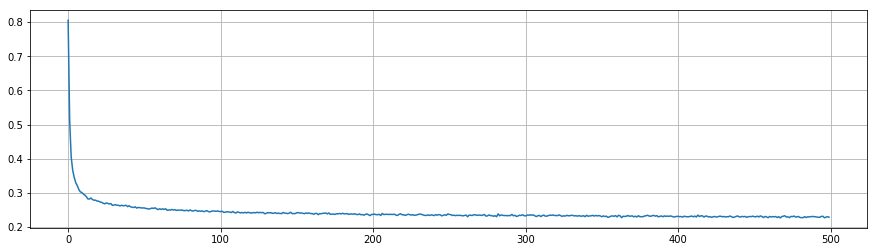

In [0]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

#Ben's testing area

In [0]:
np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(procdata, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)
second_layer = False
relu = True
if second_layer:
  nn = MLP([128,69,99,10], [None,'relu','relu', 'softmax'])
elif relu:
  nn = MLP([128,69,99,10], [None,'relu','relu', 'softmax'])
  #nn.set_early_stopping(validate, validate_target, 10)
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.1, epochs=500, mini_batch_size=32)
  print("{}s to train".format(time.time() - start))
else:
  nn = MLP([128,30,10], [None,'relu','softmax'], init_uniform=False, weight_decay=0)
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.1, epochs=500, mini_batch_size=32)
  print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

.......................

In [0]:
preds = nn.predict(validate)
calc_accuracy(labels_from_preds(preds), labels_from_preds(validate_target))

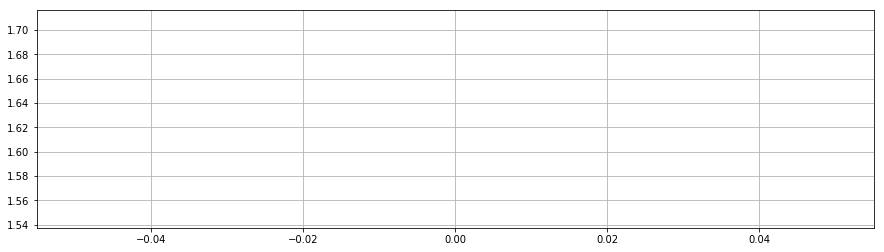

In [0]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()